# Imports 

In [1]:
from scripts.data_loading import DataLoading
from scripts.models import CrfFeatures, HMM, SpacyFit, iter_from_X_lengths, custom_t_t_split

import random
import numpy as np
import pandas as pd
import scipy.stats
from tqdm import tqdm_notebook
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline

from future.utils import iteritems

In [2]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn_crfsuite import CRF, scorers, metrics
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
import spacy
from spacy.util import minibatch, compounding
from spacy import displacy
from spacy.gold import GoldParse
from spacy.scorer import Scorer
import en_core_web_sm

In [4]:
import eli5

Using TensorFlow backend.


#### Parameters and constants 

In [5]:
PATH = r'C:\Users\Ruslan_Golubev\Documents\local_ds_files\NER - GMB\gmb-2.2.0\data'
tags_file_name = '\en.tags'
source_file_name = '\en.met'
columns = ['raw', 'pos', 'lemma', 'ner_target', 'word_net_pos', 'animacy_tag', 'title', 'date', 'genre', 'n_sent']
SEED = 77

# Data loading

In [6]:
#loading = DataLoading()
#data = loading.many_folders(PATH, source_file_name, tags_file_name, columns)

10000it [00:16, 623.55it/s]


In [7]:
#tags_df = data[['raw', 'pos', 'lemma', 'ner_target', 'title', 'n_sent']]

In [8]:
#del data

In [10]:
#data_hmm = tags_df[tags_df['raw'] != '"'].reset_index(drop=True)
#data_hmm = data_hmm.drop([117422, 569837, 1224742]) # потому что там точки задублировались 
#data_hmm.to_csv("./data_hmm.csv", index=False)

In [12]:
data = pd.read_csv('data_hmm.csv')

# EDA

In [15]:
data.head()

,raw,pos,lemma,ner_target,title,n_sent
0,Thousands,NNS,thousand,O,Thousands Protest Iraq War in London,0
1,of,IN,of,O,Thousands Protest Iraq War in London,0
2,demonstrators,NNS,demonstrator,O,Thousands Protest Iraq War in London,0
3,have,VBP,have,O,Thousands Protest Iraq War in London,0
4,marched,VBN,march,O,Thousands Protest Iraq War in London,0


In [16]:
data.shape

(1227212, 6)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1227212 entries, 0 to 1227211
Data columns (total 6 columns):
raw           1227212 non-null object
pos           1227212 non-null object
lemma         1227212 non-null object
ner_target    1227212 non-null object
title         1227212 non-null object
n_sent        1227212 non-null int64
dtypes: int64(1), object(5)
memory usage: 56.2+ MB


In [20]:
sents = loading.get_sent(data)

In [21]:
data['tags'] = [i[2] for j in sents for i in j]

In [24]:
data.head(10)

,raw,pos,lemma,ner_target,title,n_sent,tags
0,Thousands,NNS,thousand,O,Thousands Protest Iraq War in London,0,O
1,of,IN,of,O,Thousands Protest Iraq War in London,0,O
2,demonstrators,NNS,demonstrator,O,Thousands Protest Iraq War in London,0,O
3,have,VBP,have,O,Thousands Protest Iraq War in London,0,O
4,marched,VBN,march,O,Thousands Protest Iraq War in London,0,O
5,through,IN,through,O,Thousands Protest Iraq War in London,0,O
6,London,NNP,london,geo,Thousands Protest Iraq War in London,0,B-geo
7,to,TO,to,O,Thousands Protest Iraq War in London,0,O
8,protest,VB,protest,O,Thousands Protest Iraq War in London,0,O
9,the,DT,the,O,Thousands Protest Iraq War in London,0,O


In [26]:
words = list(np.unique(np.append(data["raw"].values, np.array(["<UNK>"]))))
n_words = len(words)
print(n_words)

35153


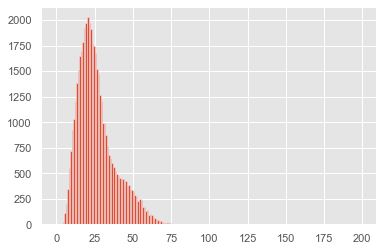

In [29]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sents], bins=[i for i in range(200)])
plt.show()

In [31]:
maxlen = max([len(s) for s in sents])
print ('Maximum sent length:', maxlen)

Maximum sent length: 91


In [32]:
for tag in data.ner_target.unique():
    print('Words with tag', tag,'\n', data.loc[data['ner_target'] == tag, 'raw'].head())

Words with tag O 
 0        Thousands
1               of
2    demonstrators
3             have
4          marched
Name: raw, dtype: object
Words with tag geo 
 6      London
12       Iraq
61       Hyde
62       Park
90    Britain
Name: raw, dtype: object
Words with tag gpe 
 18     British
98     English
109    Britain
122    British
169       Iran
Name: raw, dtype: object
Words with tag per 
 41            Bush
266      President
267        Mahmoud
268    Ahmadinejad
327         Thomas
Name: raw, dtype: object
Words with tag org 
 93             Labor
94             Party
150    International
151           Atomic
152           Energy
Name: raw, dtype: object
Words with tag tim 
 163    Wednesday
207    Wednesday
270      Tuesday
337    Wednesday
489    Wednesday
Name: raw, dtype: object
Words with tag art 
 259               Nuclear
260     Non-Proliferation
3745             Saltillo
3786            Pentastar
3787                  V-6
Name: raw, dtype: object
Words with tag nat 
 2705

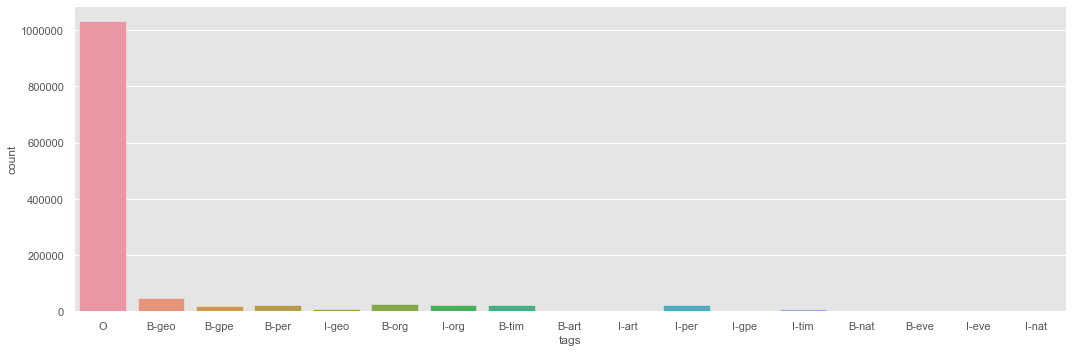

In [33]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('tags', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
plt.tight_layout()
plt.show()

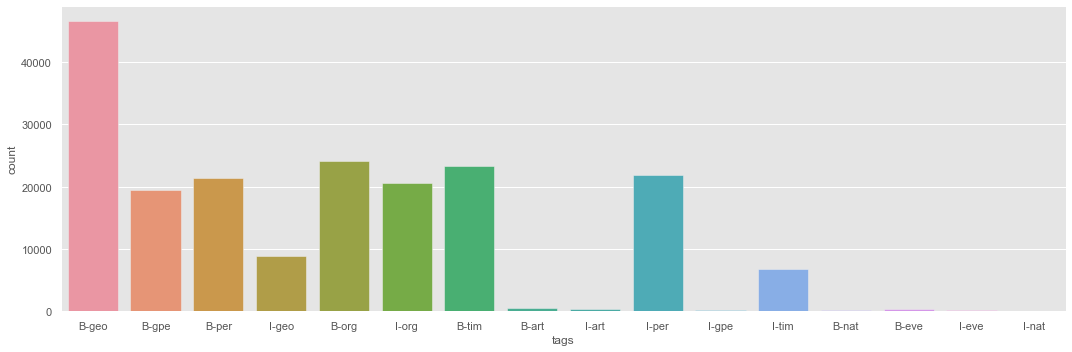

In [35]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('tags', data=data.loc[data['ner_target'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center")
plt.tight_layout()
plt.show()

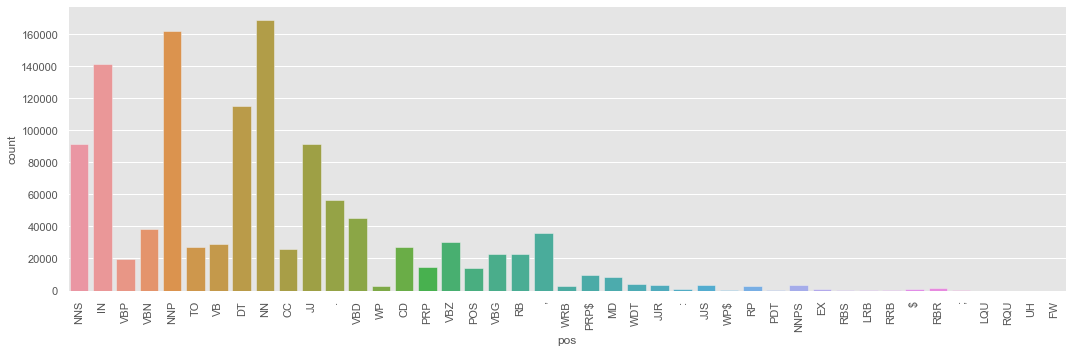

In [36]:
plt.figure(figsize=(15, 5))
ax = sns.countplot('pos', data=data, orient='h')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

# Train test split


In [64]:
data.loc[data['raw'] == '.', 'tags'] = 'Stop'
w_t = data[['raw', 'tags']].to_numpy()
tags = data['tags'].unique().tolist()
lengths = []
indexes = list(data[data['tags']=='Stop'].index)
for i in range(len(indexes)):
    if i == 0:
        lengths.append(indexes[i]+1)
    else:
        lengths.append(indexes[i]-indexes[i-1])

In [65]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [66]:
tags

['O',
 'B-geo',
 'B-gpe',
 'Stop',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

In [67]:
X_train, X_test, l_train, l_test = custom_t_t_split(w_t, lengths, test_size=0.4)

In [58]:
tags.remove('O')

In [73]:
tags

['O',
 'B-geo',
 'B-gpe',
 'Stop',
 'B-per',
 'I-geo',
 'B-org',
 'I-org',
 'B-tim',
 'B-art',
 'I-art',
 'I-per',
 'I-gpe',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat']

# HMM

In [69]:
n_components = len(tags)

In [70]:
h = HMM(n_components = n_components, gamma = 10)

In [71]:
model = h.fit(X_train, tags, l_train)

In [74]:
p = h.predict(X_test, tags, lengths=l_test)


Decoding started


In [56]:
print(classification_report(X_test[:,1], p, labels=tags, digits=3))

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           O      0.918     0.998     0.956    388972
       B-geo      0.866     0.639     0.735     18692
       B-gpe      0.983     0.535     0.693      7733
        Stop      0.999     1.000     1.000     22695
       B-per      0.919     0.476     0.627      8517
       I-geo      0.870     0.513     0.645      3476
       B-org      0.905     0.291     0.441      9816
       I-org      0.875     0.361     0.511      8498
       B-tim      0.940     0.595     0.729      9420
       B-art      0.000     0.000     0.000       170
       I-art      0.000     0.000     0.000       107
       I-per      0.833     0.628     0.716      8595
       I-gpe      0.000     0.000     0.000        85
       I-tim      0.953     0.160     0.274      2776
       B-nat      0.000     0.000     0.000        80
       B-eve      0.000     0.000     0.000       113
       I-eve      0.000     0.000     0.000       105
       I-nat      0.000    

In [16]:
print(classification_report(X_test[:,1], p, labels=tags, digits=3))

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           O      0.918     0.998     0.956    388972
       B-geo      0.866     0.639     0.735     18692
       B-gpe      0.983     0.535     0.693      7733
        Stop      0.999     1.000     1.000     22695
       B-per      0.919     0.476     0.627      8519
       I-geo      0.870     0.513     0.645      3476
       B-org      0.905     0.291     0.441      9813
       I-org      0.875     0.361     0.511      8501
       B-tim      0.940     0.595     0.729      9420
       B-art      0.000     0.000     0.000       170
       I-art      0.000     0.000     0.000       107
       I-per      0.833     0.628     0.716      8593
       I-gpe      0.000     0.000     0.000        85
       I-tim      0.953     0.160     0.274      2776
       B-nat      0.000     0.000     0.000        80
       B-eve      0.000     0.000     0.000       113
       I-eve      0.000     0.000     0.000       105
       I-nat      0.000    

# CRF

In [81]:
features = CrfFeatures()
X, y = features.run(sents)
print(y[0])
print(X[0][0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']
{'bias': 1.0, 'word.lower()': 'thousands', 'word[-3:]': 'nds', 'word[-2:]': 'ds', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'postag': 'NNS', 'postag[:2]': 'NN', 'has_hyphen': False, 'BOS': True, '+1:word.lower()': 'of', '+1:word.istitle()': False, '+1:word.isupper()': False, '+1:postag': 'IN', '+1:postag[:2]': 'IN'}


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)

In [39]:
import sklearn_crfsuite

In [41]:
crf = CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

In [42]:
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [43]:
labels = list(crf.classes_)
labels.remove('O')
labels

['B-tim',
 'B-gpe',
 'B-org',
 'B-geo',
 'B-per',
 'I-per',
 'I-org',
 'I-geo',
 'B-art',
 'I-tim',
 'B-nat',
 'B-eve',
 'I-eve',
 'I-nat',
 'I-art',
 'I-gpe']

In [44]:
y_pred = crf.predict(X_test)
sorted_labels = sorted(labels,
                       key=lambda name: (name[1:], name[0]))

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

       B-art      0.464     0.194     0.274        67
       I-art      0.435     0.172     0.247        58
       B-eve      0.440     0.262     0.328        42
       I-eve      0.167     0.129     0.145        31
       B-geo      0.868     0.917     0.892      6958
       I-geo      0.814     0.823     0.818      1270
       B-gpe      0.978     0.948     0.963      2918
       I-gpe      0.833     0.385     0.526        26
       B-nat      0.643     0.333     0.439        27
       I-nat      0.750     0.600     0.667         5
       B-org      0.822     0.749     0.784      3683
       I-org      0.817     0.805     0.811      2983
       B-per      0.867     0.854     0.861      3142
       I-per      0.851     0.911     0.880      3234
       B-tim      0.929     0.887     0.908      3466
       I-tim      0.831     0.766     0.797       998

   micro avg      0.868     0.861     0.864     28908
   macro avg      0.719   

In [45]:
eli5.show_weights(crf, top=30)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.337,0.019,-5.514,0.226,-4.721,0.677,-7.608,-0.12,-4.486,0.236,-3.95,0.668,-8.162,1.295,-7.269,0.977,-7.47
B-art,-0.7,0.0,5.665,0.0,-0.39,-0.383,-1.145,-1.405,-0.71,0.0,0.0,0.012,-2.769,-1.942,-2.713,-0.122,-1.45
I-art,-0.85,-0.747,5.268,0.0,-0.135,-0.849,-1.271,-1.132,-0.32,0.0,0.0,-0.157,-2.463,-0.729,-2.434,-1.294,-1.398
B-eve,-1.006,0.0,-0.597,-0.086,5.418,-1.488,-1.458,-1.534,-0.676,-0.168,-0.257,-1.899,-2.514,-2.232,-2.549,0.172,-1.659
I-eve,-0.507,0.0,-0.47,-2.309,4.881,-1.298,-0.811,-0.62,-0.212,0.0,0.0,-1.434,-2.139,-1.921,-1.893,-1.259,-1.786
B-geo,0.27,0.079,-2.757,0.0,-2.436,-4.131,5.389,0.12,-4.416,-0.222,-1.768,-0.487,-5.604,-1.24,-5.496,1.25,-4.147
I-geo,-0.402,1.143,-2.251,-0.436,-1.946,-3.386,4.304,-1.478,-2.74,0.0,-1.418,-1.108,-4.588,-1.101,-4.184,0.48,-3.265
B-gpe,0.618,-1.223,-2.492,-0.761,-2.684,-0.183,-4.503,-6.44,3.811,-0.108,-1.212,1.059,-6.488,-0.563,-5.066,-0.546,-3.359
I-gpe,-0.053,0.0,0.0,0.0,0.0,0.0,-0.916,-1.049,3.257,0.0,0.0,-0.607,-1.319,-0.116,-1.232,-0.968,-0.674
B-nat,-0.608,0.0,0.0,0.0,-0.151,-0.566,-0.423,-0.752,-0.328,-0.259,4.997,-0.561,-1.406,-1.068,-2.06,-0.349,-1.058


In [51]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [52]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 186.5min finished


Wall time: 3h 10min 12s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=CRF(algorithm='lbfgs', all_possible_states=None,
                                 all_possible_transitions=True, averaging=None,
                                 c=None, c1=None, c2=None,
                                 calibration_candidates=None,
                                 calibration_eta=None,
                                 calibration_max_trials=None,
                                 calibration_rate=None,
                                 calibration_samples=None, delta=None,
                                 epsilon=None, error_sensitive=None,...
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000234B5D65448>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-tim', 'B-gpe', 'B-org

In [54]:
crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.494609972678813, 'c2': 0.056639982571921405}
best CV score: 0.8562430328499818
model size: 2.00M


In [56]:
y_pred = crf.predict(X_test)
sorted_labels = sorted(labels,
                       key=lambda name: (name[1:], name[0]))

print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3))

              precision    recall  f1-score   support

       B-art      0.417     0.149     0.220        67
       I-art      0.429     0.155     0.228        58
       B-eve      0.545     0.286     0.375        42
       I-eve      0.211     0.129     0.160        31
       B-geo      0.866     0.916     0.890      6958
       I-geo      0.807     0.827     0.817      1270
       B-gpe      0.977     0.949     0.963      2918
       I-gpe      0.833     0.385     0.526        26
       B-nat      0.727     0.296     0.421        27
       I-nat      0.750     0.600     0.667         5
       B-org      0.827     0.747     0.785      3683
       I-org      0.819     0.805     0.812      2983
       B-per      0.860     0.852     0.856      3142
       I-per      0.848     0.907     0.876      3234
       B-tim      0.932     0.887     0.909      3466
       I-tim      0.840     0.762     0.799       998

   micro avg      0.867     0.859     0.863     28908
   macro avg      0.730   

# Bi-lstm

In [62]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.utils import to_categorical
from sklearn.metrics import classification_report

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [63]:
tags = h.tags

In [64]:
n_tags = len(tags)

In [65]:
X = [[word2idx[w[0]] for w in s] for s in sents]

In [67]:
X = pad_sequences(maxlen=70, sequences=X, padding="post", value=n_words - 1)

In [69]:
y_idx = [[tag2idx[w[2]] for w in s] for s in sents]
print(sents[0])
print(y_idx[0])

[('Thousands', 'NNS', 'O', 'thousand'), ('of', 'IN', 'O', 'of'), ('demonstrators', 'NNS', 'O', 'demonstrator'), ('have', 'VBP', 'O', 'have'), ('marched', 'VBN', 'O', 'march'), ('through', 'IN', 'O', 'through'), ('London', 'NNP', 'B-geo', 'london'), ('to', 'TO', 'O', 'to'), ('protest', 'VB', 'O', 'protest'), ('the', 'DT', 'O', 'the'), ('war', 'NN', 'O', 'war'), ('in', 'IN', 'O', 'in'), ('Iraq', 'NNP', 'B-geo', 'iraq'), ('and', 'CC', 'O', 'and'), ('demand', 'VB', 'O', 'demand'), ('the', 'DT', 'O', 'the'), ('withdrawal', 'NN', 'O', 'withdrawal'), ('of', 'IN', 'O', 'of'), ('British', 'JJ', 'B-gpe', 'uk'), ('troops', 'NNS', 'O', 'troops'), ('from', 'IN', 'O', 'from'), ('that', 'DT', 'O', 'that'), ('country', 'NN', 'O', 'country'), ('.', '.', 'O', '.')]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]


In [93]:
y = pad_sequences(maxlen=70, sequences=y_idx, padding="post", value=tag2idx["O"])
print(y[0])

[0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [77]:
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [52]:
model = Sequential()
model.add(Embedding(input_dim=n_words+1, output_dim=200, input_length=70))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(n_tags, activation="relu")))
crf_layer = CRF(n_tags)
model.add(crf_layer)

In [93]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 200)           7030800   
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 200)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 70, 256)           336896    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 70, 18)            4626      
_________________________________________________________________
crf_1 (CRF)                  (None, 70, 18)            702       
Total params: 7,373,024
Trainable params: 7,373,024
Non-trainable params: 0
_________________________________________________________________


In [54]:
# adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer='adam', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [56]:
history = model.fit(X_train, np.array(y_train), batch_size=128, epochs=20,
                    validation_split=0.1, verbose=1)

C:\Users\Ruslan_Golubev\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 36499 samples, validate on 4056 samples
Epoch 1/20
18560/36499 [==============>...............] - ETA: 7:25 - loss: 2.9203 - crf_viterbi_accuracy: 0.00 - ETA: 5:45 - loss: 2.8939 - crf_viterbi_accuracy: 0.00 - ETA: 5:13 - loss: 2.8680 - crf_viterbi_accuracy: 0.00 - ETA: 4:56 - loss: 2.8380 - crf_viterbi_accuracy: 0.00 - ETA: 4:47 - loss: 2.8011 - crf_viterbi_accuracy: 0.00 - ETA: 4:42 - loss: 2.7545 - crf_viterbi_accuracy: 0.03 - ETA: 4:38 - loss: 2.6886 - crf_viterbi_accuracy: 0.12 - ETA: 4:36 - loss: 2.6040 - crf_viterbi_accuracy: 0.21 - ETA: 4:33 - loss: 2.4989 - crf_viterbi_accuracy: 0.29 - ETA: 4:31 - loss: 2.3817 - crf_viterbi_accuracy: 0.35 - ETA: 4:30 - loss: 2.2620 - crf_viterbi_accuracy: 0.41 - ETA: 4:30 - loss: 2.1465 - crf_viterbi_accuracy: 0.45 - ETA: 4:28 - loss: 2.0373 - crf_viterbi_accuracy: 0.49 - ETA: 4:28 - loss: 1.9359 - crf_viterbi_accuracy: 0.52 - ETA: 4:26 - loss: 1.8458 - crf_viterbi_accuracy: 0.55 - ETA: 4:25 - loss: 1.7664 - crf_viterbi_accuracy: 0.57

18688/36499 [==============>...............] - ETA: 5:40 - loss: 0.1123 - crf_viterbi_accuracy: 0.96 - ETA: 5:39 - loss: 0.1059 - crf_viterbi_accuracy: 0.96 - ETA: 5:39 - loss: 0.1051 - crf_viterbi_accuracy: 0.96 - ETA: 5:39 - loss: 0.1056 - crf_viterbi_accuracy: 0.96 - ETA: 5:38 - loss: 0.1068 - crf_viterbi_accuracy: 0.96 - ETA: 5:38 - loss: 0.1062 - crf_viterbi_accuracy: 0.96 - ETA: 5:36 - loss: 0.1089 - crf_viterbi_accuracy: 0.96 - ETA: 5:33 - loss: 0.1087 - crf_viterbi_accuracy: 0.96 - ETA: 5:33 - loss: 0.1105 - crf_viterbi_accuracy: 0.96 - ETA: 5:31 - loss: 0.1088 - crf_viterbi_accuracy: 0.96 - ETA: 5:30 - loss: 0.1071 - crf_viterbi_accuracy: 0.96 - ETA: 5:30 - loss: 0.1067 - crf_viterbi_accuracy: 0.96 - ETA: 5:30 - loss: 0.1072 - crf_viterbi_accuracy: 0.96 - ETA: 5:29 - loss: 0.1067 - crf_viterbi_accuracy: 0.96 - ETA: 5:28 - loss: 0.1076 - crf_viterbi_accuracy: 0.96 - ETA: 5:26 - loss: 0.1067 - crf_viterbi_accuracy: 0.96 - ETA: 5:25 - loss: 0.1066 - crf_viterbi_accuracy: 0.96 - E

36499/36499 [==============================] - ETA: 2:52 - loss: 0.0879 - crf_viterbi_accuracy: 0.97 - ETA: 2:51 - loss: 0.0877 - crf_viterbi_accuracy: 0.97 - ETA: 2:50 - loss: 0.0876 - crf_viterbi_accuracy: 0.97 - ETA: 2:49 - loss: 0.0875 - crf_viterbi_accuracy: 0.97 - ETA: 2:48 - loss: 0.0874 - crf_viterbi_accuracy: 0.97 - ETA: 2:47 - loss: 0.0873 - crf_viterbi_accuracy: 0.97 - ETA: 2:45 - loss: 0.0872 - crf_viterbi_accuracy: 0.97 - ETA: 2:44 - loss: 0.0871 - crf_viterbi_accuracy: 0.97 - ETA: 2:43 - loss: 0.0869 - crf_viterbi_accuracy: 0.97 - ETA: 2:42 - loss: 0.0868 - crf_viterbi_accuracy: 0.97 - ETA: 2:40 - loss: 0.0868 - crf_viterbi_accuracy: 0.97 - ETA: 2:39 - loss: 0.0867 - crf_viterbi_accuracy: 0.97 - ETA: 2:38 - loss: 0.0865 - crf_viterbi_accuracy: 0.97 - ETA: 2:37 - loss: 0.0864 - crf_viterbi_accuracy: 0.97 - ETA: 2:35 - loss: 0.0862 - crf_viterbi_accuracy: 0.97 - ETA: 2:34 - loss: 0.0860 - crf_viterbi_accuracy: 0.97 - ETA: 2:33 - loss: 0.0860 - crf_viterbi_accuracy: 0.97 - E

18688/36499 [==============>...............] - ETA: 5:45 - loss: 0.0158 - crf_viterbi_accuracy: 0.99 - ETA: 5:41 - loss: 0.0175 - crf_viterbi_accuracy: 0.99 - ETA: 5:38 - loss: 0.0213 - crf_viterbi_accuracy: 0.98 - ETA: 5:36 - loss: 0.0192 - crf_viterbi_accuracy: 0.98 - ETA: 5:35 - loss: 0.0198 - crf_viterbi_accuracy: 0.98 - ETA: 5:34 - loss: 0.0192 - crf_viterbi_accuracy: 0.99 - ETA: 5:34 - loss: 0.0189 - crf_viterbi_accuracy: 0.99 - ETA: 5:34 - loss: 0.0196 - crf_viterbi_accuracy: 0.98 - ETA: 5:34 - loss: 0.0206 - crf_viterbi_accuracy: 0.98 - ETA: 5:34 - loss: 0.0206 - crf_viterbi_accuracy: 0.98 - ETA: 5:33 - loss: 0.0210 - crf_viterbi_accuracy: 0.98 - ETA: 5:31 - loss: 0.0216 - crf_viterbi_accuracy: 0.98 - ETA: 5:30 - loss: 0.0211 - crf_viterbi_accuracy: 0.98 - ETA: 5:29 - loss: 0.0217 - crf_viterbi_accuracy: 0.98 - ETA: 5:28 - loss: 0.0217 - crf_viterbi_accuracy: 0.98 - ETA: 5:26 - loss: 0.0212 - crf_viterbi_accuracy: 0.98 - ETA: 5:26 - loss: 0.0215 - crf_viterbi_accuracy: 0.98 - E

36499/36499 [==============================] - ETA: 2:49 - loss: 0.0191 - crf_viterbi_accuracy: 0.98 - ETA: 2:48 - loss: 0.0191 - crf_viterbi_accuracy: 0.98 - ETA: 2:47 - loss: 0.0191 - crf_viterbi_accuracy: 0.98 - ETA: 2:46 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:45 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:43 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:42 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:41 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:40 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:39 - loss: 0.0190 - crf_viterbi_accuracy: 0.98 - ETA: 2:38 - loss: 0.0189 - crf_viterbi_accuracy: 0.98 - ETA: 2:37 - loss: 0.0189 - crf_viterbi_accuracy: 0.98 - ETA: 2:35 - loss: 0.0189 - crf_viterbi_accuracy: 0.98 - ETA: 2:34 - loss: 0.0188 - crf_viterbi_accuracy: 0.98 - ETA: 2:33 - loss: 0.0188 - crf_viterbi_accuracy: 0.98 - ETA: 2:32 - loss: 0.0188 - crf_viterbi_accuracy: 0.98 - ETA: 2:31 - loss: 0.0188 - crf_viterbi_accuracy: 0.98 - E

17792/36499 [=============>................] - ETA: 5:32 - loss: 0.0016 - crf_viterbi_accuracy: 0.99 - ETA: 5:33 - loss: 0.0027 - crf_viterbi_accuracy: 0.99 - ETA: 5:35 - loss: 2.5117e-04 - crf_viterbi_accuracy: 0.99 - ETA: 5:36 - loss: 3.8512e-04 - crf_viterbi_accuracy: 0.99 - ETA: 5:35 - loss: 2.8645e-04 - crf_viterbi_accuracy: 0.99 - ETA: 5:34 - loss: 0.0016 - crf_viterbi_accuracy: 0.9912   - ETA: 5:34 - loss: 0.0017 - crf_viterbi_accuracy: 0.99 - ETA: 5:34 - loss: 0.0026 - crf_viterbi_accuracy: 0.99 - ETA: 5:33 - loss: 0.0019 - crf_viterbi_accuracy: 0.99 - ETA: 5:32 - loss: 0.0019 - crf_viterbi_accuracy: 0.99 - ETA: 5:31 - loss: 0.0019 - crf_viterbi_accuracy: 0.99 - ETA: 5:30 - loss: 0.0020 - crf_viterbi_accuracy: 0.99 - ETA: 5:28 - loss: 0.0015 - crf_viterbi_accuracy: 0.99 - ETA: 5:28 - loss: 0.0014 - crf_viterbi_accuracy: 0.99 - ETA: 5:26 - loss: 0.0015 - crf_viterbi_accuracy: 0.99 - ETA: 5:26 - loss: 0.0010 - crf_viterbi_accuracy: 0.99 - ETA: 5:25 - loss: 0.0012 - crf_viterbi_ac

35072/36499 [===========================>..] - ETA: 2:59 - loss: 6.3897e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:57 - loss: 6.0498e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:56 - loss: 5.6409e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:55 - loss: 5.7235e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:54 - loss: 5.7738e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:52 - loss: 5.9263e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:51 - loss: 6.1906e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:50 - loss: 6.8670e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:49 - loss: 6.8029e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:47 - loss: 6.3041e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:46 - loss: 5.8088e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:45 - loss: 5.7297e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:44 - loss: 6.1180e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:42 - loss: 6.1341e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:41 - loss: 6.0850e-04 - crf_viterbi_accuracy: 0.99 - ETA: 2:40 - loss: 5.8625e-04 - crf_viterbi_accuracy: 

36499/36499 [==============================] - ETA: 12s - loss: -4.6796e-04 - crf_viterbi_accuracy: 0.99 - ETA: 11s - loss: -4.9521e-04 - crf_viterbi_accuracy: 0.99 - ETA: 10s - loss: -5.1039e-04 - crf_viterbi_accuracy: 0.99 - ETA: 8s - loss: -5.2753e-04 - crf_viterbi_accuracy: 0.9914 - ETA: 7s - loss: -5.3917e-04 - crf_viterbi_accuracy: 0.991 - ETA: 6s - loss: -5.5555e-04 - crf_viterbi_accuracy: 0.991 - ETA: 5s - loss: -5.6196e-04 - crf_viterbi_accuracy: 0.991 - ETA: 3s - loss: -5.6605e-04 - crf_viterbi_accuracy: 0.991 - ETA: 2s - loss: -5.5131e-04 - crf_viterbi_accuracy: 0.991 - ETA: 1s - loss: -5.5078e-04 - crf_viterbi_accuracy: 0.991 - ETA: 0s - loss: -5.4742e-04 - crf_viterbi_accuracy: 0.991 - 361s 10ms/step - loss: -5.5098e-04 - crf_viterbi_accuracy: 0.9914 - val_loss: 0.0069 - val_crf_viterbi_accuracy: 0.9881
Epoch 7/20
18048/36499 [=============>................] - ETA: 5:49 - loss: -0.0069 - crf_viterbi_accuracy: 0.992 - ETA: 5:49 - loss: -0.0062 - crf_viterbi_accuracy: 0.993 

18048/36499 [=============>................] - ETA: 5:42 - loss: -0.0135 - crf_viterbi_accuracy: 0.991 - ETA: 5:41 - loss: -0.0104 - crf_viterbi_accuracy: 0.991 - ETA: 5:42 - loss: -0.0106 - crf_viterbi_accuracy: 0.992 - ETA: 5:44 - loss: -0.0100 - crf_viterbi_accuracy: 0.992 - ETA: 5:44 - loss: -0.0099 - crf_viterbi_accuracy: 0.991 - ETA: 5:44 - loss: -0.0101 - crf_viterbi_accuracy: 0.992 - ETA: 5:43 - loss: -0.0099 - crf_viterbi_accuracy: 0.992 - ETA: 5:43 - loss: -0.0097 - crf_viterbi_accuracy: 0.992 - ETA: 5:41 - loss: -0.0097 - crf_viterbi_accuracy: 0.992 - ETA: 5:40 - loss: -0.0100 - crf_viterbi_accuracy: 0.992 - ETA: 5:39 - loss: -0.0100 - crf_viterbi_accuracy: 0.992 - ETA: 5:38 - loss: -0.0097 - crf_viterbi_accuracy: 0.992 - ETA: 5:37 - loss: -0.0094 - crf_viterbi_accuracy: 0.991 - ETA: 5:36 - loss: -0.0097 - crf_viterbi_accuracy: 0.992 - ETA: 5:34 - loss: -0.0095 - crf_viterbi_accuracy: 0.992 - ETA: 5:34 - loss: -0.0096 - crf_viterbi_accuracy: 0.992 - ETA: 5:32 - loss: -0.0100

36499/36499 [==============================] - ETA: 0s - loss: -0.0132 - crf_viterbi_accuracy: 0.992 - 368s 10ms/step - loss: -0.0132 - crf_viterbi_accuracy: 0.9924 - val_loss: -0.0029 - val_crf_viterbi_accuracy: 0.9882
Epoch 9/20
18048/36499 [=============>................] - ETA: 5:54 - loss: -0.0185 - crf_viterbi_accuracy: 0.995 - ETA: 5:56 - loss: -0.0180 - crf_viterbi_accuracy: 0.993 - ETA: 5:55 - loss: -0.0182 - crf_viterbi_accuracy: 0.993 - ETA: 5:54 - loss: -0.0178 - crf_viterbi_accuracy: 0.993 - ETA: 5:50 - loss: -0.0178 - crf_viterbi_accuracy: 0.993 - ETA: 5:49 - loss: -0.0180 - crf_viterbi_accuracy: 0.993 - ETA: 5:48 - loss: -0.0183 - crf_viterbi_accuracy: 0.993 - ETA: 5:47 - loss: -0.0181 - crf_viterbi_accuracy: 0.993 - ETA: 5:46 - loss: -0.0182 - crf_viterbi_accuracy: 0.993 - ETA: 5:44 - loss: -0.0184 - crf_viterbi_accuracy: 0.993 - ETA: 5:44 - loss: -0.0183 - crf_viterbi_accuracy: 0.993 - ETA: 5:43 - loss: -0.0178 - crf_viterbi_accuracy: 0.993 - ETA: 5:41 - loss: -0.0179 

18048/36499 [=============>................] - ETA: 5:51 - loss: -0.0190 - crf_viterbi_accuracy: 0.991 - ETA: 5:52 - loss: -0.0213 - crf_viterbi_accuracy: 0.992 - ETA: 5:50 - loss: -0.0222 - crf_viterbi_accuracy: 0.992 - ETA: 5:50 - loss: -0.0220 - crf_viterbi_accuracy: 0.992 - ETA: 5:49 - loss: -0.0209 - crf_viterbi_accuracy: 0.992 - ETA: 5:48 - loss: -0.0212 - crf_viterbi_accuracy: 0.992 - ETA: 5:48 - loss: -0.0211 - crf_viterbi_accuracy: 0.992 - ETA: 5:47 - loss: -0.0219 - crf_viterbi_accuracy: 0.992 - ETA: 5:45 - loss: -0.0215 - crf_viterbi_accuracy: 0.992 - ETA: 5:45 - loss: -0.0216 - crf_viterbi_accuracy: 0.992 - ETA: 5:43 - loss: -0.0218 - crf_viterbi_accuracy: 0.992 - ETA: 5:42 - loss: -0.0213 - crf_viterbi_accuracy: 0.992 - ETA: 5:41 - loss: -0.0213 - crf_viterbi_accuracy: 0.992 - ETA: 5:40 - loss: -0.0211 - crf_viterbi_accuracy: 0.992 - ETA: 5:39 - loss: -0.0212 - crf_viterbi_accuracy: 0.992 - ETA: 5:37 - loss: -0.0213 - crf_viterbi_accuracy: 0.992 - ETA: 5:36 - loss: -0.0215

36499/36499 [==============================] - ETA: 0s - loss: -0.0243 - crf_viterbi_accuracy: 0.993 - 370s 10ms/step - loss: -0.0243 - crf_viterbi_accuracy: 0.9933 - val_loss: -0.0107 - val_crf_viterbi_accuracy: 0.9883
Epoch 11/20
18048/36499 [=============>................] - ETA: 5:46 - loss: -0.0319 - crf_viterbi_accuracy: 0.995 - ETA: 5:51 - loss: -0.0285 - crf_viterbi_accuracy: 0.994 - ETA: 5:50 - loss: -0.0279 - crf_viterbi_accuracy: 0.993 - ETA: 5:47 - loss: -0.0270 - crf_viterbi_accuracy: 0.993 - ETA: 5:49 - loss: -0.0274 - crf_viterbi_accuracy: 0.993 - ETA: 5:48 - loss: -0.0274 - crf_viterbi_accuracy: 0.993 - ETA: 5:48 - loss: -0.0273 - crf_viterbi_accuracy: 0.993 - ETA: 5:47 - loss: -0.0271 - crf_viterbi_accuracy: 0.993 - ETA: 5:45 - loss: -0.0266 - crf_viterbi_accuracy: 0.993 - ETA: 5:44 - loss: -0.0267 - crf_viterbi_accuracy: 0.993 - ETA: 5:43 - loss: -0.0264 - crf_viterbi_accuracy: 0.993 - ETA: 5:42 - loss: -0.0265 - crf_viterbi_accuracy: 0.993 - ETA: 5:40 - loss: -0.0266

18048/36499 [=============>................] - ETA: 5:52 - loss: -0.0325 - crf_viterbi_accuracy: 0.991 - ETA: 5:54 - loss: -0.0335 - crf_viterbi_accuracy: 0.992 - ETA: 5:54 - loss: -0.0321 - crf_viterbi_accuracy: 0.993 - ETA: 5:55 - loss: -0.0324 - crf_viterbi_accuracy: 0.993 - ETA: 5:54 - loss: -0.0319 - crf_viterbi_accuracy: 0.993 - ETA: 5:52 - loss: -0.0326 - crf_viterbi_accuracy: 0.993 - ETA: 5:52 - loss: -0.0326 - crf_viterbi_accuracy: 0.993 - ETA: 5:50 - loss: -0.0325 - crf_viterbi_accuracy: 0.993 - ETA: 5:49 - loss: -0.0325 - crf_viterbi_accuracy: 0.993 - ETA: 5:49 - loss: -0.0322 - crf_viterbi_accuracy: 0.993 - ETA: 5:49 - loss: -0.0323 - crf_viterbi_accuracy: 0.993 - ETA: 5:48 - loss: -0.0324 - crf_viterbi_accuracy: 0.993 - ETA: 5:47 - loss: -0.0324 - crf_viterbi_accuracy: 0.993 - ETA: 5:45 - loss: -0.0325 - crf_viterbi_accuracy: 0.993 - ETA: 5:44 - loss: -0.0325 - crf_viterbi_accuracy: 0.993 - ETA: 5:43 - loss: -0.0324 - crf_viterbi_accuracy: 0.993 - ETA: 5:41 - loss: -0.0326

36499/36499 [==============================] - ETA: 0s - loss: -0.0347 - crf_viterbi_accuracy: 0.993 - 370s 10ms/step - loss: -0.0347 - crf_viterbi_accuracy: 0.9939 - val_loss: -0.0179 - val_crf_viterbi_accuracy: 0.9880
Epoch 13/20
18048/36499 [=============>................] - ETA: 5:58 - loss: -0.0393 - crf_viterbi_accuracy: 0.994 - ETA: 5:56 - loss: -0.0382 - crf_viterbi_accuracy: 0.993 - ETA: 5:53 - loss: -0.0391 - crf_viterbi_accuracy: 0.994 - ETA: 5:52 - loss: -0.0390 - crf_viterbi_accuracy: 0.994 - ETA: 5:49 - loss: -0.0388 - crf_viterbi_accuracy: 0.994 - ETA: 5:50 - loss: -0.0392 - crf_viterbi_accuracy: 0.994 - ETA: 5:51 - loss: -0.0389 - crf_viterbi_accuracy: 0.994 - ETA: 5:52 - loss: -0.0389 - crf_viterbi_accuracy: 0.994 - ETA: 5:52 - loss: -0.0391 - crf_viterbi_accuracy: 0.994 - ETA: 5:51 - loss: -0.0390 - crf_viterbi_accuracy: 0.994 - ETA: 5:50 - loss: -0.0391 - crf_viterbi_accuracy: 0.994 - ETA: 5:50 - loss: -0.0390 - crf_viterbi_accuracy: 0.994 - ETA: 5:48 - loss: -0.0391

18048/36499 [=============>................] - ETA: 6:00 - loss: -0.0435 - crf_viterbi_accuracy: 0.994 - ETA: 5:59 - loss: -0.0446 - crf_viterbi_accuracy: 0.994 - ETA: 5:59 - loss: -0.0440 - crf_viterbi_accuracy: 0.994 - ETA: 5:59 - loss: -0.0439 - crf_viterbi_accuracy: 0.994 - ETA: 5:58 - loss: -0.0442 - crf_viterbi_accuracy: 0.994 - ETA: 5:56 - loss: -0.0446 - crf_viterbi_accuracy: 0.995 - ETA: 5:54 - loss: -0.0446 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0443 - crf_viterbi_accuracy: 0.994 - ETA: 5:53 - loss: -0.0445 - crf_viterbi_accuracy: 0.995 - ETA: 5:52 - loss: -0.0443 - crf_viterbi_accuracy: 0.995 - ETA: 5:51 - loss: -0.0443 - crf_viterbi_accuracy: 0.995 - ETA: 5:50 - loss: -0.0445 - crf_viterbi_accuracy: 0.995 - ETA: 5:49 - loss: -0.0445 - crf_viterbi_accuracy: 0.995 - ETA: 5:47 - loss: -0.0444 - crf_viterbi_accuracy: 0.995 - ETA: 5:46 - loss: -0.0444 - crf_viterbi_accuracy: 0.995 - ETA: 5:45 - loss: -0.0444 - crf_viterbi_accuracy: 0.995 - ETA: 5:44 - loss: -0.0442

36499/36499 [==============================] - ETA: 1s - loss: -0.0447 - crf_viterbi_accuracy: 0.994 - ETA: 0s - loss: -0.0447 - crf_viterbi_accuracy: 0.994 - 375s 10ms/step - loss: -0.0447 - crf_viterbi_accuracy: 0.9945 - val_loss: -0.0256 - val_crf_viterbi_accuracy: 0.9876
Epoch 15/20
18048/36499 [=============>................] - ETA: 5:57 - loss: -0.0480 - crf_viterbi_accuracy: 0.994 - ETA: 5:54 - loss: -0.0460 - crf_viterbi_accuracy: 0.994 - ETA: 5:55 - loss: -0.0475 - crf_viterbi_accuracy: 0.994 - ETA: 5:56 - loss: -0.0475 - crf_viterbi_accuracy: 0.994 - ETA: 5:55 - loss: -0.0469 - crf_viterbi_accuracy: 0.994 - ETA: 5:54 - loss: -0.0474 - crf_viterbi_accuracy: 0.994 - ETA: 5:53 - loss: -0.0477 - crf_viterbi_accuracy: 0.994 - ETA: 5:52 - loss: -0.0478 - crf_viterbi_accuracy: 0.994 - ETA: 5:51 - loss: -0.0480 - crf_viterbi_accuracy: 0.994 - ETA: 5:50 - loss: -0.0480 - crf_viterbi_accuracy: 0.994 - ETA: 5:48 - loss: -0.0481 - crf_viterbi_accuracy: 0.994 - ETA: 5:47 - loss: -0.0481 -

18048/36499 [=============>................] - ETA: 6:01 - loss: -0.0550 - crf_viterbi_accuracy: 0.996 - ETA: 6:01 - loss: -0.0552 - crf_viterbi_accuracy: 0.996 - ETA: 5:59 - loss: -0.0552 - crf_viterbi_accuracy: 0.996 - ETA: 5:57 - loss: -0.0552 - crf_viterbi_accuracy: 0.996 - ETA: 5:56 - loss: -0.0548 - crf_viterbi_accuracy: 0.996 - ETA: 5:54 - loss: -0.0540 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0540 - crf_viterbi_accuracy: 0.995 - ETA: 5:51 - loss: -0.0537 - crf_viterbi_accuracy: 0.995 - ETA: 5:51 - loss: -0.0537 - crf_viterbi_accuracy: 0.995 - ETA: 5:49 - loss: -0.0532 - crf_viterbi_accuracy: 0.995 - ETA: 5:48 - loss: -0.0533 - crf_viterbi_accuracy: 0.995 - ETA: 5:47 - loss: -0.0530 - crf_viterbi_accuracy: 0.995 - ETA: 5:46 - loss: -0.0531 - crf_viterbi_accuracy: 0.995 - ETA: 5:45 - loss: -0.0532 - crf_viterbi_accuracy: 0.995 - ETA: 5:44 - loss: -0.0533 - crf_viterbi_accuracy: 0.995 - ETA: 5:43 - loss: -0.0530 - crf_viterbi_accuracy: 0.995 - ETA: 5:42 - loss: -0.0531

36499/36499 [==============================] - ETA: 1s - loss: -0.0543 - crf_viterbi_accuracy: 0.994 - ETA: 0s - loss: -0.0543 - crf_viterbi_accuracy: 0.994 - 375s 10ms/step - loss: -0.0543 - crf_viterbi_accuracy: 0.9949 - val_loss: -0.0315 - val_crf_viterbi_accuracy: 0.9875
Epoch 17/20
18048/36499 [=============>................] - ETA: 5:55 - loss: -0.0561 - crf_viterbi_accuracy: 0.993 - ETA: 5:56 - loss: -0.0597 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0583 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0586 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0588 - crf_viterbi_accuracy: 0.995 - ETA: 5:52 - loss: -0.0589 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0588 - crf_viterbi_accuracy: 0.995 - ETA: 5:50 - loss: -0.0588 - crf_viterbi_accuracy: 0.995 - ETA: 5:49 - loss: -0.0588 - crf_viterbi_accuracy: 0.995 - ETA: 5:48 - loss: -0.0589 - crf_viterbi_accuracy: 0.995 - ETA: 5:47 - loss: -0.0589 - crf_viterbi_accuracy: 0.995 - ETA: 5:45 - loss: -0.0585 -

18048/36499 [=============>................] - ETA: 6:00 - loss: -0.0617 - crf_viterbi_accuracy: 0.995 - ETA: 5:56 - loss: -0.0618 - crf_viterbi_accuracy: 0.995 - ETA: 5:52 - loss: -0.0630 - crf_viterbi_accuracy: 0.996 - ETA: 5:51 - loss: -0.0625 - crf_viterbi_accuracy: 0.995 - ETA: 5:50 - loss: -0.0627 - crf_viterbi_accuracy: 0.995 - ETA: 5:51 - loss: -0.0631 - crf_viterbi_accuracy: 0.995 - ETA: 5:50 - loss: -0.0637 - crf_viterbi_accuracy: 0.996 - ETA: 5:50 - loss: -0.0635 - crf_viterbi_accuracy: 0.996 - ETA: 5:48 - loss: -0.0633 - crf_viterbi_accuracy: 0.996 - ETA: 5:47 - loss: -0.0633 - crf_viterbi_accuracy: 0.996 - ETA: 5:45 - loss: -0.0630 - crf_viterbi_accuracy: 0.995 - ETA: 5:44 - loss: -0.0632 - crf_viterbi_accuracy: 0.996 - ETA: 5:44 - loss: -0.0632 - crf_viterbi_accuracy: 0.996 - ETA: 5:42 - loss: -0.0634 - crf_viterbi_accuracy: 0.996 - ETA: 5:41 - loss: -0.0633 - crf_viterbi_accuracy: 0.996 - ETA: 5:40 - loss: -0.0633 - crf_viterbi_accuracy: 0.996 - ETA: 5:39 - loss: -0.0631

36499/36499 [==============================] - ETA: 0s - loss: -0.0639 - crf_viterbi_accuracy: 0.995 - 371s 10ms/step - loss: -0.0639 - crf_viterbi_accuracy: 0.9955 - val_loss: -0.0387 - val_crf_viterbi_accuracy: 0.9873
Epoch 19/20
18048/36499 [=============>................] - ETA: 5:59 - loss: -0.0619 - crf_viterbi_accuracy: 0.994 - ETA: 5:57 - loss: -0.0655 - crf_viterbi_accuracy: 0.995 - ETA: 5:56 - loss: -0.0655 - crf_viterbi_accuracy: 0.995 - ETA: 5:58 - loss: -0.0663 - crf_viterbi_accuracy: 0.995 - ETA: 5:58 - loss: -0.0668 - crf_viterbi_accuracy: 0.995 - ETA: 5:58 - loss: -0.0669 - crf_viterbi_accuracy: 0.996 - ETA: 5:58 - loss: -0.0669 - crf_viterbi_accuracy: 0.996 - ETA: 5:56 - loss: -0.0668 - crf_viterbi_accuracy: 0.995 - ETA: 5:55 - loss: -0.0668 - crf_viterbi_accuracy: 0.995 - ETA: 5:54 - loss: -0.0669 - crf_viterbi_accuracy: 0.995 - ETA: 5:53 - loss: -0.0669 - crf_viterbi_accuracy: 0.995 - ETA: 5:52 - loss: -0.0672 - crf_viterbi_accuracy: 0.996 - ETA: 5:51 - loss: -0.0673

18048/36499 [=============>................] - ETA: 6:00 - loss: -0.0707 - crf_viterbi_accuracy: 0.995 - ETA: 5:59 - loss: -0.0722 - crf_viterbi_accuracy: 0.996 - ETA: 5:58 - loss: -0.0724 - crf_viterbi_accuracy: 0.996 - ETA: 5:57 - loss: -0.0728 - crf_viterbi_accuracy: 0.996 - ETA: 5:54 - loss: -0.0728 - crf_viterbi_accuracy: 0.996 - ETA: 5:53 - loss: -0.0723 - crf_viterbi_accuracy: 0.996 - ETA: 5:53 - loss: -0.0725 - crf_viterbi_accuracy: 0.996 - ETA: 5:51 - loss: -0.0729 - crf_viterbi_accuracy: 0.996 - ETA: 5:49 - loss: -0.0729 - crf_viterbi_accuracy: 0.996 - ETA: 5:48 - loss: -0.0727 - crf_viterbi_accuracy: 0.996 - ETA: 5:47 - loss: -0.0726 - crf_viterbi_accuracy: 0.996 - ETA: 5:46 - loss: -0.0727 - crf_viterbi_accuracy: 0.996 - ETA: 5:45 - loss: -0.0726 - crf_viterbi_accuracy: 0.996 - ETA: 5:43 - loss: -0.0725 - crf_viterbi_accuracy: 0.996 - ETA: 5:42 - loss: -0.0726 - crf_viterbi_accuracy: 0.996 - ETA: 5:41 - loss: -0.0726 - crf_viterbi_accuracy: 0.996 - ETA: 5:39 - loss: -0.0726

36499/36499 [==============================] - ETA: 0s - loss: -0.0731 - crf_viterbi_accuracy: 0.995 - 372s 10ms/step - loss: -0.0731 - crf_viterbi_accuracy: 0.9958 - val_loss: -0.0441 - val_crf_viterbi_accuracy: 0.9872


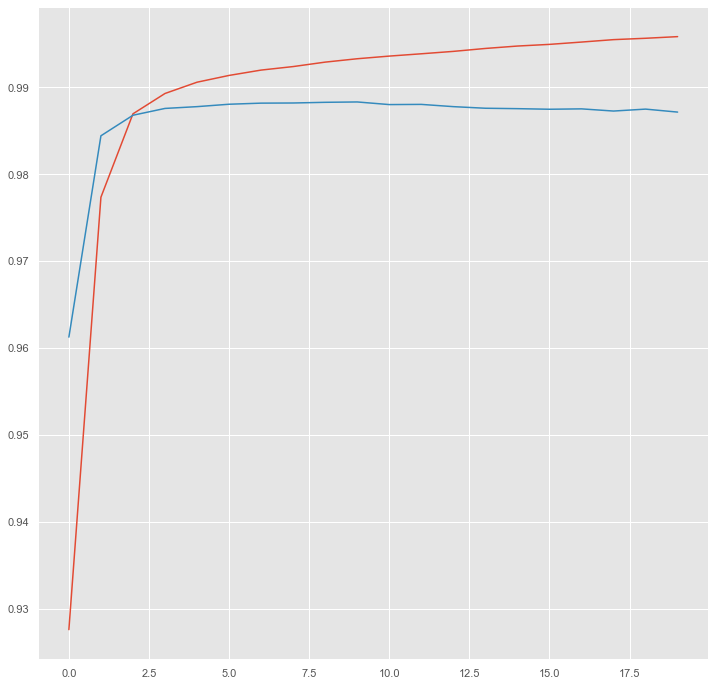

In [62]:
hist = pd.DataFrame(history.history)
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["crf_viterbi_accuracy"])
plt.plot(hist["val_crf_viterbi_accuracy"])
plt.show()

In [66]:
test_pred = model.predict(X_test, verbose=1)

7157/7157 [==============================] - ETA: 45 - ETA: 29 - ETA: 23 - ETA: 21 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 

In [67]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

In [82]:
len(pred_labels[0])

70

In [68]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 83.4%


In [89]:
print(classification_report(np.argmax(test_pred, 2).ravel(), np.argmax(y_test, axis=2).ravel(), labels=list(idx2tag.keys()), target_names=list(idx2tag.values())))

              precision    recall  f1-score   support

         unk       0.00      0.00      0.00         0
           O       1.00      1.00      1.00    472878
       B-tim       0.89      0.89      0.89      3515
       B-gpe       0.95      0.97      0.96      2899
       B-org       0.68      0.82      0.74      2982
       B-geo       0.89      0.87      0.88      7186
       B-per       0.83      0.84      0.84      3197
       I-per       0.87      0.86      0.86      3368
       I-org       0.71      0.85      0.77      2598
       I-geo       0.80      0.79      0.79      1294
       B-art       0.08      0.38      0.13        16
       I-tim       0.72      0.77      0.74       962
       B-nat       0.19      0.71      0.30         7
       B-eve       0.23      0.42      0.30        26
       I-eve       0.14      0.19      0.16        26
       I-nat       0.00      0.00      0.00         1
       I-art       0.07      0.20      0.10        15
       I-gpe       0.50    

In [95]:
model.evaluate(X_test, np.array(y_test))

7157/7157 [==============================] - ETA: 20 - ETA: 17 - ETA: 15 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  

[-0.045051815682355625, 0.9877971410751343]

In [105]:
i = 1444
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))

Word           ||True ||Pred
truckload      : B-gpe B-gpe
evident        : O     O
Palin          : O     O
ITV1           : B-per B-per
Blantyre       : I-per I-per
responsible    : O     O
Joanne         : B-per B-per
rubies         : O     O
Diplomats      : O     O
rulers         : O     O
Susy           : O     O
exterminate    : O     O
Barghouti      : O     O
placed         : O     O
criminal       : O     O
scoop          : O     O
Terrorist      : O     O
dazed          : O     O
mockery        : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
association    : O     O
assoc

# Spacy

In [38]:
data_test = tags_df[tags_df['raw'] != '"'][['raw', 'tags']]

In [40]:
data_test.head(60)

,raw,tags
0,Thousands,O
1,of,O
2,demonstrators,O
3,have,O
4,marched,O
5,through,O
6,London,B-geo
7,to,O
8,protest,O
9,the,O


In [26]:
SpacyPreparation = SpacyFit()
spacy_data = SpacyPreparation.run(data_test)

In [27]:
spacy_data[0]

('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country ',
 {'entities': [(48, 54, 'B-geo'), (77, 81, 'B-geo'), (111, 118, 'B-gpe')]})

In [28]:
# checking data for empty sentences
[print(sent) for sent in spacy_data if sent[0] == '']

[]

In [31]:
TRAIN_DATA = spacy_data[:40000]
LABEL = []
for _, annotations in spacy_data:
        for ent in annotations.get("entities"):
            LABEL.append(ent[2])
LABEL = list(set(LABEL))

In [32]:
LABEL

['I-per',
 'I-org',
 'I-gpe',
 'B-art',
 'B-nat',
 'B-per',
 'B-eve',
 'I-tim',
 'I-eve',
 'I-nat',
 'B-org',
 'B-gpe',
 'I-art',
 'B-tim',
 'B-geo',
 'I-geo']

In [33]:
model=None
n_iter=50

"""Setting up the pipeline and entity recognizer, and training the new entity."""
if model is not None:
    nlp = spacy.load(model)  # load existing spacy model
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  # create blank Language class
    print("Created blank 'en' model")

if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner)
else:
    ner = nlp.get_pipe('ner')

for i in set(LABEL):
    ner.add_label(i)   # Add new entity labels to entity recognizer

if model is None:
    optimizer = nlp.begin_training()
else:
    optimizer = nlp.entity.create_optimizer()

# Get names of other pipes to disable them during training to train only NER
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        batches = minibatch(TRAIN_DATA, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.35,
                       losses=losses)
        print('Losses', losses)

Created blank 'en' model
Losses {'ner': 70267.23360237689}
Losses {'ner': 55142.40632621676}
Losses {'ner': 51127.31712444102}
Losses {'ner': 48599.64056626616}
Losses {'ner': 46577.82533627102}
Losses {'ner': 44881.16291816673}
Losses {'ner': 43489.95224132894}
Losses {'ner': 42597.26145456456}
Losses {'ner': 41550.64825942571}
Losses {'ner': 40916.375903313456}
Losses {'ner': 40184.398001815076}
Losses {'ner': 39510.5506134196}
Losses {'ner': 39092.83371877264}
Losses {'ner': 38211.159791918304}
Losses {'ner': 37837.52468341047}
Losses {'ner': 37295.12261849903}
Losses {'ner': 36933.21403725336}
Losses {'ner': 36465.2384858093}
Losses {'ner': 36108.2522981212}
Losses {'ner': 35947.11868482827}
Losses {'ner': 35541.173474727504}
Losses {'ner': 35218.99320137907}
Losses {'ner': 35054.33326144273}
Losses {'ner': 34671.91217232281}
Losses {'ner': 34643.75976961611}
Losses {'ner': 34225.70177014486}
Losses {'ner': 33830.68582543877}
Losses {'ner': 33845.83725190649}
Losses {'ner': 33584.0

In [ ]:
# loading existing model
'''output_dir = 'spacy_model'
new_model_name = 'spacy_model'
output_dir = Path(output_dir)
if not output_dir.exists():
    output_dir.mkdir()
nlp.meta['name'] = new_model_name  # rename model
nlp.to_disk(output_dir)
print("Saved model to", output_dir)
nlp2 = spacy.load(output_dir)

doc2 = nlp2(test_text)
for ent in doc2.ents:
    print(ent.label_, ent.text)
'''

In [66]:
test_data = spacy_data[40000:] 

In [82]:
# in notebook entities are marked
random.seed(SEED)
sample = random.sample(test_data, 10)
for i in sample:
    displacy.render(nlp(str(i[0])), jupyter=True, style='ent')

In [106]:
def evaluate(ner_model, examples):

    scorer = Scorer()
    for input_, annot in tqdm_notebook(examples):
        doc_gold_text = ner_model.make_doc(input_)
        gold = GoldParse(doc_gold_text, entities=annot.get('entities'))
        pred_value = ner_model(input_)
        scorer.score(pred_value, gold)
    return scorer.scores

In [107]:
score = evaluate(nlp, test_data)

In [114]:
score

{'uas': 0.0,
 'las': 0.0,
 'las_per_type': {'': {'p': 0.0, 'r': 0.0, 'f': 0.0}},
 'ents_p': 84.90313018315277,
 'ents_r': 84.86419753086419,
 'ents_f': 84.88365939280612,
 'ents_per_type': {'B-art': {'p': 51.85185185185185,
   'r': 10.9375,
   'f': 18.064516129032256},
  'B-org': {'p': 79.58781633580845,
   'r': 72.92418772563177,
   'f': 76.11042678066808},
  'B-geo': {'p': 85.78694546482058,
   'r': 90.31682284694334,
   'f': 87.99362365046012},
  'B-tim': {'p': 92.57314328582146,
   'r': 88.89209047687653,
   'f': 90.69528149345876},
  'I-tim': {'p': 79.29318068690891,
   'r': 77.82120175867122,
   'f': 78.55029585798817},
  'B-per': {'p': 80.02782501159376,
   'r': 84.21994468846592,
   'f': 82.0703868103995},
  'B-gpe': {'p': 92.1869425615412,
   'r': 95.1574295709814,
   'f': 93.64863640482014},
  'I-geo': {'p': 80.62745098039215,
   'r': 82.47091857200161,
   'f': 81.53876660717827},
  'I-per': {'p': 82.67241379310344,
   'r': 91.34783298936338,
   'f': 86.79387585790784},
  'I-

## Pre-trained Spacy

In [115]:
pr_nlp = en_core_web_sm.load()

In [118]:
doc = pr_nlp('European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
print([(X.text, X.label_) for X in doc.ents])

[('European', 'NORP'), ('Google', 'ORG'), ('$5.1 billion', 'MONEY'), ('Wednesday', 'DATE')]


In [119]:
print([(X, X.ent_iob_, X.ent_type_) for X in doc])

[(European, 'B', 'NORP'), (authorities, 'O', ''), (fined, 'O', ''), (Google, 'B', 'ORG'), (a, 'O', ''), (record, 'O', ''), ($, 'B', 'MONEY'), (5.1, 'I', 'MONEY'), (billion, 'I', 'MONEY'), (on, 'O', ''), (Wednesday, 'B', 'DATE'), (for, 'O', ''), (abusing, 'O', ''), (its, 'O', ''), (power, 'O', ''), (in, 'O', ''), (the, 'O', ''), (mobile, 'O', ''), (phone, 'O', ''), (market, 'O', ''), (and, 'O', ''), (ordered, 'O', ''), (the, 'O', ''), (company, 'O', ''), (to, 'O', ''), (alter, 'O', ''), (its, 'O', ''), (practices, 'O', '')]


Replaced our tags with spacy tags and deleted 'B-nat' and 'I-nat'

In [156]:
r_dict = {
    'B-per' : 'PERSON',
    'I-per' : 'PERSON',
    'B-geo' : 'LOC',
    'I-geo' : 'LOC',
    'B-org' : 'ORG',
    'I-org' : 'ORG',
    'B-gpe' : 'GPE',
    'I-gpe' : 'GPE',
    'B-art' : 'WORK_OF_ART',
    'I-art' : 'WORK_OF_ART',
    'B-eve' : 'EVENT',
    'I-eve' : 'EVENT',
    'B-tim' : 'DATE',
    'I-tim' : 'DATE'
        }
pr_test_data = []
for sent, ent in tqdm_notebook(test_data):
    entities = {'entities' : []}
    for i in ent['entities']:
        if 'I-nat' not in i and 'B-nat' not in i:
            lst = list(i)
            lst[2] = r_dict[lst[2]]
            entities['entities'].append(tuple(lst))
    pr_test_data.append((sent, entities))

In [169]:
score = evaluate(pr_nlp, pr_test_data)

In [182]:
[(key,item) for key, item in score['ents_per_type'].items() if key in r_dict.values()]

[('GPE',
  {'p': 2.027180927795915, 'r': 4.858078602620088, 'f': 2.8606632024428134}),
 ('ORG',
  {'p': 35.96449516563639, 'r': 16.935363487087628, 'f': 23.02735068757294}),
 ('LOC',
  {'p': 40.582959641255606, 'r': 2.271158792897923, 'f': 4.301586358505139}),
 ('WORK_OF_ART',
  {'p': 3.125, 'r': 0.9615384615384616, 'f': 1.4705882352941175}),
 ('DATE',
  {'p': 53.318611213348056, 'r': 48.353360035603025, 'f': 50.71474415076725}),
 ('PERSON',
  {'p': 27.723874662000952, 'r': 14.004499437570303, 'f': 18.608872043986548}),
 ('EVENT',
  {'p': 0.3703703703703704,
   'r': 0.5747126436781609,
   'f': 0.45045045045045046})]